In [ ]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize,sent_tokenize
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
nltk.download('stopwords')
nltk.download('punkt')
from gensim.models import Word2Vec
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K
from sklearn.metrics import mean_squared_error
from sklearn.metrics import cohen_kappa_score

In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c asap-aes

In [ ]:
df = pd.read_csv("/content/training_set_rel3.tsv.zip", sep='\t', encoding='ISO-8859-1');
df.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.shape

(12976, 28)

In [ ]:
df.dropna(axis=1,inplace=True)
df.drop(columns=['rater1_domain1','rater2_domain1'],inplace=True,axis=1)

In [ ]:
df.shape

(12976, 4)

In [ ]:
df.head()

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8


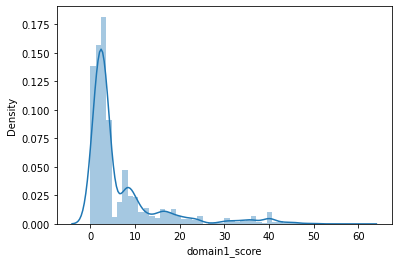

In [ ]:
#Check Skewness
sns.distplot(df['domain1_score'])

In [ ]:
min_range = [2,1,0,0,0,0,0,0]
max_range = [12,6,3,3,4,4,30,60]

def normalize(x,mi,ma):
    x = (x-mi)/(ma-mi)
    return round(x*10)

df['final_score']=df.apply(lambda x:normalize(x['domain1_score'],min_range[x['essay_set']-1],max_range[x['essay_set']-1]),axis=1)

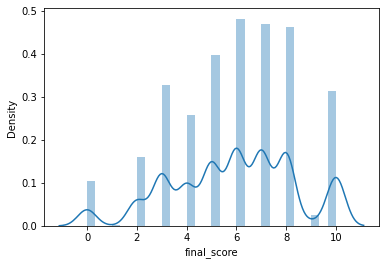

In [ ]:
sns.distplot(df['final_score'])

In [ ]:
df.drop('domain1_score',axis=1,inplace=True)

In [ ]:
df.head()

,essay_id,essay_set,essay,final_score
0,1,1,"Dear local newspaper, I think effects computer...",6
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",7
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",5
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",8
4,5,1,"Dear @LOCATION1, I know having computers has a...",6


In [ ]:
#Make Dataset
y = df['final_score']
X=df

In [ ]:
X

,essay_id,essay_set,essay,final_score
0,1,1,"Dear local newspaper, I think effects computer...",6
1,2,1,Dear I believe that using computers will benef...,7
2,3,1,"Dear, More and more people use computers, but ...",5
3,4,1,"Dear Local Newspaper, I have found that many e...",8
4,5,1,Dear I know having computers has a positive ef...,6
...,...,...,...,...
12971,21626,8,In most stories mothers and daughters are eith...,6
12972,21628,8,I never understood the meaning laughter is the...,5
12973,21629,8,"When you laugh, is out of habit, or is cause? ...",7
12974,21630,8,"Trippin' on fences I am years young, and in th...",7


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train.shape

(9083, 4)

In [ ]:
#Preprocessing
train_e = X_train['essay'].tolist()
test_e = X_test['essay'].tolist()

train_sents=[]
test_sents=[]

def clean_essay(essay):
    x=[]
    for i in essay.split():
        if i.startswith("@"):
            continue
        else:
            x.append(i)
    return ' '.join(x)
df['essay'] = df['essay'].apply(lambda x:clean_essay(x))

stop_words = set(stopwords.words('english')) 
def sent2word(x):
    x=re.sub("[^A-Za-z]"," ",x)
    x.lower()
    filtered_sentence = [] 
    words=x.split()
    for w in words:
        if w not in stop_words: 
            filtered_sentence.append(w)
    return filtered_sentence

def essay2word(essay):
    essay = essay.strip()
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw = tokenizer.tokenize(essay)
    final_words=[]
    for i in raw:
        if(len(i)>0):
            final_words.append(sent2word(i))
    return final_words

for i in train_e:
    train_sents+=essay2word(i)

for i in test_e:
    test_sents+=essay2word(i)

In [ ]:
len(train_sents)
train_sents[0]

['It',
 'first',
 'day',
 'high',
 'school',
 'gut',
 'full',
 'butterflies',
 'make',
 'want',
 'run',
 'bathrooms',
 'hide',
 'world']

In [ ]:
#start from here anvita: Preparing WORD2VEC and LSTM Model, training & testing, and graph